# <center> Calibrating the QICK for phase coherent readout

### <center> In this demo you will calibrate the QICK clocks to have the same phase.

Before you measure a resonance with your QICK this is the first calibration you should do. It is a calibration for the two synthesizers which belong to the QICK signal generator and the QICK readout, respectively. The two synthesizers are running at the same frequency, but there is initially a constant phase difference $\phi$ between these two synthesizers. Doing this calibration results in you finding that phase difference $\phi$. In your subsequent measurements, you can specify this initial phase difference $\phi$ to compensate for it. From then on, the signal generator can synthesize any frequency and then if you read in data (doing a digital down conversion in the process), the readout will still be phase coherent with respect to the signal generator. 

<center> The angular frequency $\omega = 2 \pi f$ .

<center> Also, $\phi = (\omega t) + \phi_0$. 

<center> So, $\phi = (2 \pi f)*t + \phi_0 $. 

If $f$ goes up linearly, the phase difference will also change linearly (it will either increase or decrease, depending on whether the readout is ahead or behind of the signal generator- this is randomly determined each time the board clocks are initialized). Once the phase hits 360 degrees it cycles back to 0 again. For a readout frequency of interest $f_i$ there is a corresponding phase difference $\phi_i$. In this demonstration we assume $f_i \approx 180$ MHz. You can plot $\phi(f)$ and evaluate $\phi(f_i)=\phi_i$.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick.qick import *

In [2]:
# Load bitstream with custom overlay
soc = Qick('../qick_lib/qick.bit',ignore_version=True, force_init_clks=False)


### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0
* This program has an associated assembly language file which needs to be located in the same directory when you run it: <code> phase_calibration.asm </code>


In [3]:
# Constant, real envelope.
xg_i = 30000*np.ones(320)
xg_q = np.zeros(len(xg_i))

# Upload waveform.
gen = soc.gens[6].load(addr=0,xin_i=xg_i, xin_q=xg_q)

# Output frequency f0_v.
###################
# Try it yourself ! Change the output frequency.
###################
# f0_v = np.linspace(180,180.006,70)
f0_v = np.linspace(420,421,30) 

fi_v = np.zeros(len(f0_v))
td_v = np.zeros(len(f0_v))
for ii in np.arange(len(f0_v)):
    f0 = f0_v[ii]
    
    f0_dac_int = freq2reg(fs=soc.fs_dac,f=f0, B=32) # Frequency of signal generator
    soc.tproc.single_write(addr=123, data=f0_dac_int)

    # Output phase.
    fi0 = 0
    tmp = phase2reg(fi0,B=32)
    soc.tproc.single_write(addr=124, data=tmp)

    # Configure readout.
    soc.readouts[0].set_out("product")
    #soc.readouts[0].set_freq(f0)
    soc.readouts[0].set_freq_int(2*f0_dac_int) # Using the same frequency multiplied by 2
    soc.avg_bufs[0].config(address=0, length=1000)
    soc.avg_bufs[0].enable()
    
#     time.sleep(1)

    # Load program.
    soc.tproc.load_program("01_phase_calibration.asm")

    # Start tProc.
    soc.tproc.stop()
    soc.tproc.start()

    time.sleep(0.1)

    # Get data.
    [xi,xq] = soc.get_decimated(ch=0, length=1000)
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.sum(x)/len(x)

    # Calculate calibration phase.
    A = np.abs(xavg)
    fi = np.angle(xavg,deg=True)
    if fi<0:
        fi = fi+360

    print("Iteration i = %d, freq_i = %f MHz, phi_i = %f degrees" %(ii,f0, fi))
    
    # Save results.
    fi_v[ii] = fi

Iteration i = 0, freq_i = 420.000000 MHz, phi_i = 327.626277 degrees
Iteration i = 1, freq_i = 420.034483 MHz, phi_i = 306.897736 degrees
Iteration i = 2, freq_i = 420.068966 MHz, phi_i = 286.143771 degrees
Iteration i = 3, freq_i = 420.103448 MHz, phi_i = 265.419979 degrees
Iteration i = 4, freq_i = 420.137931 MHz, phi_i = 244.667331 degrees
Iteration i = 5, freq_i = 420.172414 MHz, phi_i = 223.930862 degrees
Iteration i = 6, freq_i = 420.206897 MHz, phi_i = 203.068635 degrees
Iteration i = 7, freq_i = 420.241379 MHz, phi_i = 182.326599 degrees
Iteration i = 8, freq_i = 420.275862 MHz, phi_i = 161.586622 degrees
Iteration i = 9, freq_i = 420.310345 MHz, phi_i = 140.839417 degrees
Iteration i = 10, freq_i = 420.344828 MHz, phi_i = 120.085483 degrees
Iteration i = 11, freq_i = 420.379310 MHz, phi_i = 99.233603 degrees
Iteration i = 12, freq_i = 420.413793 MHz, phi_i = 78.472465 degrees
Iteration i = 13, freq_i = 420.448276 MHz, phi_i = 57.741651 degrees
Iteration i = 14, freq_i = 420.48

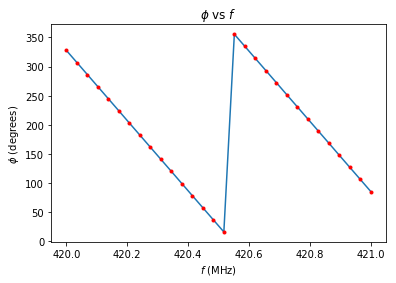

In [4]:
# Plot results.
plt.figure(2)
plt.plot(f0_v,fi_v)
plt.plot(f0_v,fi_v, marker='.', linestyle="None",color="Red")
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.savefig("images/Phase_calibration.pdf", dpi=350)

For example, if your cavity tone was generated with an IF of 420.9 MHz, you would look at the above table and see that <code> freq_i </code> = 420.9 MHz corresponds to <code> phi_i </code> = 308.7 degrees (that's specific to this board session, for your QICK it will be different). That value of <code> phi_i </code> will be used as the value of the <code> config </code> file parameter associated with the offset phase of the cavity pulse (the parameter is called <code> res_phase </code> in the demo 00_Send_recieve_pulse).